## SDSS spectral analyzer to infer stellar distances
### Written by Caden Gobat for ASTR 3141 at the George Washington University

In [56]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, pickle, scipy, astropy.coordinates as coord, astropy.units as u
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from PyAstronomy import pyasl
mpl.rcParams['font.family'] = 'serif'

In [51]:
full_catalog = pd.read_csv('SDSS12query_TOP99999.csv') # culled to only include *stars* with a quality rating of 3 (max)
full_catalog.rename(columns={'RA_ICRS': 'RA','DE_ICRS': 'DE','Sp-ID': 'SpID'}, inplace=True)
ugriz = {'umag':355.1,'gmag':468.6,'rmag':616.5,'imag':748.1,'zmag':893.1}
lumClasses = ['Ia', 'Ia+', 'Iab', 'Ib', 'II', 'III', 'IV', 'V']
# https://en.wikipedia.org/wiki/Photometric_system for info on ugriz band letters

In [26]:
objList = full_catalog.copy().drop(['ObsDate','spType','pmRA','pmDE','chi2'],axis=1).dropna(subset=['subCl']) # unnecessary data
objList = objList[[any(Cl[0]==x for x in list("OBAFGKM")) & any(x in Cl for x in lumClasses) for Cl in objList.subCl]]
for i in objList.index: # the above drops everything that is not a star with a standard spectral class. This loop parses the class
    Cl = objList.loc[i,'subCl'].strip().split()[0] # discard everything after a space, if one exists
    Cl = Cl.split('/')[-1] # take the second part after a /, if one exists
    objList.loc[i,'subCl'] = Cl # reassign the clean subCl
with open('goodfits.pkl','rb') as fitfile: # the model was run and dumped to a pickle file for easy access
    goodfits = pickle.load(fitfile)
with open('goodtemps.pkl','rb') as tempfile:
    goodtemps = pickle.load(tempfile)
all_good = list(set(goodtemps) & set(goodfits))

In [27]:
all_good.sort()

In [63]:
def planck(wavelength,T,amp): #in nm
    h = 6.626e-34 # Planck's constant, J*s
    c = 299792458 # speed of light, m/s
    k = 1.38064852e-23 # Boltzmann constant, J/K
    B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law
    return B # W/m^2/nm

def wien(T):
    b = 2.897771955e-3 # Wien's displacement constant, in m*K
    λ_max = (b/T)*1e9 # Wien's Law, with λ converted from nm
    return λ_max # in K


def ugriz_to_UBVRI(mags): # Jordi et al. (2006)
    u,g,r,i,z = [mag for mag in mags]
    
    UB = 0.79*(u-g) - 0.93 #U-B = (0.79±0.02)*(u-g) - (0.93±0.02)
    B = 0.313*(g-r) + 0.219 + g #B-g = (0.313±0.003)*(g-r) + (0.219±0.002)
    if  g-i <= 2.1:
        VI = 0.675*(g-i)  + 0.364 #V-I = (0.675±0.002)*(g-i) + (0.364±0.002) if g-i <= 2.1
    elif g-i > 2.1:
        VI = 1.11*(g-i) - 0.52 #V-I = (1.11±0.02)*(g-i) - (0.52±0.05) if  g-i >  2.1
    R = -0.153*(r-i) - 0.117 + r #R-r = (-0.153±0.003)*(r-i) - (0.117±0.003)
    I = -0.386*(i-z) - 0.397 + i #I-i = (-0.386±0.004)*(i-z) - (0.397±0.001)
    U = UB + B
    V = VI + I

    return U,B,V,R,I


def ugriz_to_flux(ugrizmags,errors=np.zeros(5)):
    UBVRI = dict(zip(["U","B","V","R","I"],ugriz_to_UBVRI(ugrizmags))) 

    maxmag, minmag = ugriz_to_UBVRI(ugrizmags-errors), ugriz_to_UBVRI(ugrizmags+errors)
    fluxes, wavelengths, maxflux, minflux = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])
    
    for i in range(len(UBVRI)):
        fluxes[i], wavelengths[i] = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], UBVRI[list(UBVRI)[i]], "lam") # in CGS & Å
        maxflux[i], _ = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], maxmag[i], "lam")
        minflux[i], _ = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], minmag[i], "lam")
    
    wavelengths *= 0.1 # Ang to nm
    fluxes *= 1e-4*0.1/1e-7 # erg/s/cm^2/Ang to W/m^2/nm
    minflux *= 1e-4*0.1/1e-7
    maxflux *= 1e-4*0.1/1e-7
    
    negerrors, poserrors = fluxes-minflux, maxflux-fluxes
    
    return pd.DataFrame(zip(UBVRI.keys(),wavelengths,fluxes,negerrors,poserrors),columns=('band','wavelength','flux','e_neg','e_pos'))


def calculate(obj):
    magnitudes = np.array(objList.loc[obj,ugriz.keys()])
    errors = np.array(objList.loc[obj,['e_'+band for band in ugriz.keys()]])

    spectrum = ugriz_to_flux(magnitudes,errors)
    
    fit_params, cov_mat = curve_fit(planck, spectrum['wavelength'], spectrum['flux'], p0=[7000,1e-30])
    uncertainties = np.sqrt(np.diag(cov_mat))
    T = fit_params[0]
    amp = fit_params[1]
    λ_max = wien(T) # in nm, from temperature in K
    baseλ = np.arange(250,1050)
    
    spectrum['fit'] = planck(spectrum['wavelength'],*fit_params)
    conf_region = (planck(baseλ,T-uncertainties[0],amp-uncertainties[1]), planck(baseλ,T+uncertainties[0],amp+uncertainties[1]))
    fluxerrors = [spectrum['e_neg'],spectrum['e_pos']]


    fit_residual = spectrum['flux'] - spectrum['fit']
    fit_Rsquared = 1 - np.var(fit_residual)/np.var(spectrum['flux'])
    fit_Chi_sq = np.sum((spectrum['flux'] - spectrum['fit'])**2/spectrum['fit'])
    
    lumClass  = objList.loc[obj,'subCl'][2:].strip()
    specClass = objList.loc[obj,'subCl'][:2]
    Cl = specClass+lumClass

    loglum, logTeff = sdj.lumAndTeff(specClass, lumClass)
    lum, Teff = (10**loglum)*3.828e26, 10**logTeff
    intFlux = np.sum(planck(np.arange(1,4000),*fit_params))
    dist = np.sqrt(lum/(4*np.pi*intFlux))
    
    return dist, Teff-T


sdj = pyasl.SpecTypeDeJager()

### Create and fit the blackbody spectrum

In [22]:
# Select object and obtain magnitudes
objIndex = np.random.choice(all_good) # pick a star to analyze
obj = int(objIndex) #3792, 7935, 96757
SpID = objList.loc[obj,'SpID'] # parse plate, mjd, and fiber info
magnitudes = np.array(objList.loc[obj,ugriz.keys()]) # read the values of the magnitudes in each of the five ugriz channels
errors = np.array(objList.loc[obj,['e_'+band for band in ugriz.keys()]]) # read the corresponding rms errors

spectrum = ugriz_to_flux(magnitudes,errors)
print(f"#{obj} loaded successfully")

# Fit data

fit_params, cov_mat = curve_fit(planck, spectrum['wavelength'], spectrum['flux'], p0=[7000,1e-30]) # (function,x,data,starting guesses)
uncertainties = np.sqrt(np.diag(cov_mat))
T = fit_params[0]
amp = fit_params[1]
λ_max = wien(T) # in nm, from temperature in K
baseλ = np.arange(250,1050)

spectrum['fit'] = planck(spectrum['wavelength'],*fit_params)
conf_region = (planck(baseλ,T-uncertainties[0],amp-uncertainties[1]), planck(baseλ,T+uncertainties[0],amp+uncertainties[1]))
fluxerrors = [spectrum['e_neg'],spectrum['e_pos']]


fit_residual = spectrum['flux'] - spectrum['fit']
fit_Rsquared = 1 - np.var(fit_residual)/np.var(spectrum['flux'])
fit_Chi_sq = np.sum((spectrum['flux'] - spectrum['fit'])**2/spectrum['fit'])

caption = "Obj temperature: %.2f \u00b1 %.3f K \nScaling factor: %.3e \u00b1 %.3e \nSpectrum peak λ: %.2f \u00b1 %.3f nm \nFit R-squared: %f" %(fit_params[0],uncertainties[0],fit_params[1],uncertainties[1],λ_max,wien(T)-wien(T+uncertainties[0]),fit_Rsquared)
print(caption)


# Calculate temp and luminosity based on stellar class

lumClass  = objList.loc[obj,'subCl'][2:].strip()
specClass = objList.loc[obj,'subCl'][:2]
Cl = specClass+lumClass

loglum, logTeff = sdj.lumAndTeff(specClass, lumClass)
lum, Teff = (10**loglum)*3.828e26, 10**logTeff
print("Stellar class: %s \nLuminosity: %.4e W \nTemperature: %.4f K" %(Cl,lum,Teff))
intFlux = np.sum(planck(np.arange(1,4000),*fit_params))
dist = np.sqrt(lum/(4*np.pi*intFlux))
print("Distance: %.4e m (%.1f ly)" %(dist,dist/9460730000000000))

#45638 loaded successfully
Obj temperature: 6424.78 ± 155.053 K 
Scaling factor: 3.489e-28 ± 4.051e-29 
Spectrum peak λ: 451.03 ± 10.628 nm 
Fit R-squared: 0.960632
Stellar class: F5V 
Luminosity: 7.9390e+26 W 
Temperature: 6341.1778 K
Distance: 2.4352e+18 m (257.4 ly)


c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


### Plot the data and model

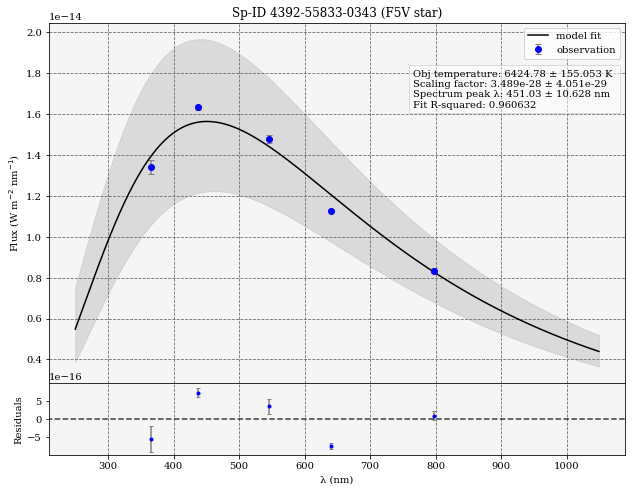

In [23]:
#Create main spectrum plot

fig, ax = plt.subplots(figsize=(8, 5))
fig.set_facecolor('white')

#Plot Data-model
main_frame = fig.add_axes((0,.2,1,1)).set_facecolor('whitesmoke')
plt.errorbar(spectrum['wavelength'],spectrum['flux'],fmt='ob',yerr=fluxerrors,ecolor='grey',label='observation',capsize=3)
plt.plot(baseλ, planck(baseλ,*fit_params), color='black',label='model fit')
plt.fill_between(baseλ, *conf_region, color='silver', alpha=.5)
plt.ylabel("Flux (W m$^{-2}$ nm$^{-1}$)")
xlimits = plt.gca().get_xlim()
plt.title(f"Sp-ID {SpID} ({Cl} star)")
plt.legend()
plt.grid(color='dimgrey', linestyle='--')

#Residual plot
res_frame = fig.add_axes((0,0,1,.2)).set_facecolor('whitesmoke')
plt.errorbar(spectrum['wavelength'],fit_residual,fmt='.b',yerr=fluxerrors,ecolor='grey',capsize=2)
plt.plot([0,2000],[0,0],'--k',alpha=.75) # 0 baseline
plt.ylabel('Residuals')
plt.gca().set_xlim(xlimits)
plt.gca().set_ylim(-1*max(np.abs(plt.gca().get_ylim())),max(np.abs(plt.gca().get_ylim())))
plt.gca().xaxis.grid(color='dimgrey', linestyle='--')
plt.xlabel("λ (nm)")
fig.text(.632,.965,caption,bbox=dict(facecolor='w',edgecolor='silver',alpha=0.5))
plt.savefig(f'example_{obj}.png',bbox_inches='tight')

### Create visualizations of spectral class temperature/luminosity relations

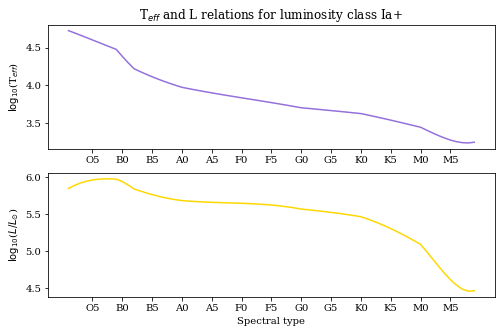

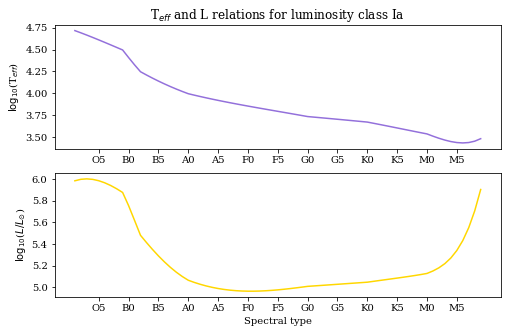

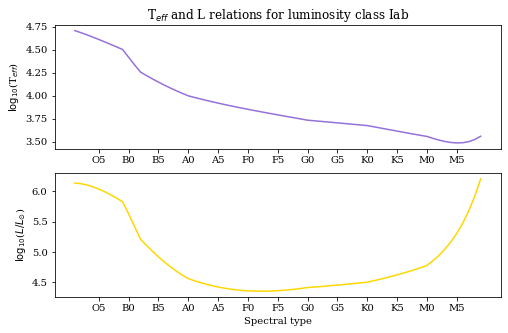

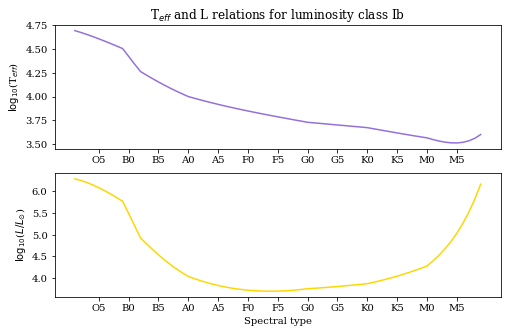

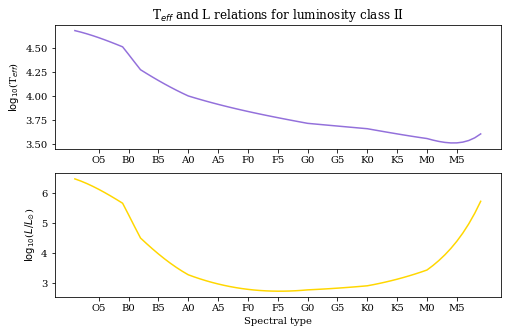

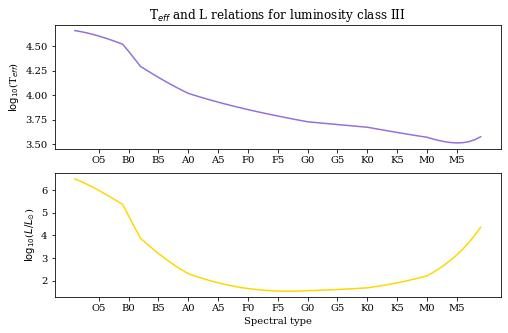

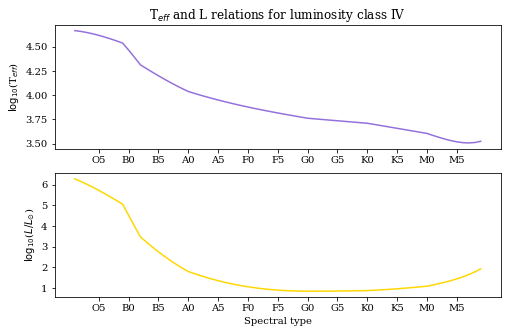

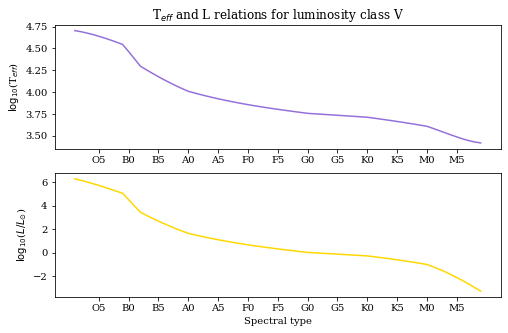

In [8]:
for lumClass in lumClasses:
    # Save spectral types, log(teff), and log(luminosity)
    spts = []
    lteffs = []
    llums = []

    # Save information to mark up x-axis
    xt = []
    xtl = []

    for t in "OBAFGKM":
        for n in range(10):
            if (t == "O") and (n == 0):
                # "O0" type doesn't exist
                continue

            # Save the spectral type
            spts.append(t + str(n))

            # Get log10 of luminosity and effective temperature
            ll, lt = sdj.lumAndTeff(spts[-1], lumClass)
            # and save to lists
            llums.append(ll)
            lteffs.append(lt)

            if (n == 0) or (n == 5):
                xt.append(len(spts)-1)
                xtl.append(spts[-1])

    fig, _ = plt.subplots(figsize=(8,5))
    ax1 = plt.subplot(2,1,1)
    # Plot log10(effective temperature)
    plt.plot(lteffs, color='mediumpurple')
    plt.title("T$_{eff}$ and L relations for luminosity class %s" %lumClass)
    plt.ylabel("$\log_{10}$(T$_{eff}$)")
    plt.setp(ax1, xticks=xt,xticklabels=xtl)
    ax2 = plt.subplot(2,1,2)
    # Plot log10(luminosity)
    plt.plot(llums, color='gold')
    plt.ylabel("$\log_{10}$($L/L_{\odot}$)")
    plt.setp(ax2, xticks=xt,xticklabels=xtl)
    plt.xlabel("Spectral type")
    plt.savefig(f'TandL_{lumClass}.png')

### Invoke the above fitting algorithm to calculate distances for a multitude of stars

In [64]:
distances = pd.Series([])
tempdiffs = pd.Series([])
for i in all_good:
    distances[i], tempdiffs[i] = calculate(i)
    print("", end=f"\rObject #{i} of {max(all_good)} completed. ({int(100*len(distances)/len(all_good))}%)")

c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Object #99978 of 99978 completed. (100%)

In [10]:
# Mini five-point plots
'''
ugrizSpec.plot(kind='scatter',x='wavelength',y='ugriz_mag',color='red',marker='o',title=f'Object {SpID}: ugriz magnitude plot\n').set(xlabel='Wavelength (nm)',ylabel='Visual magnitude (urgriz)')
plt.show()
print(ugrizSpec)
plt.plot(UBVRIspec['wavelength'],UBVRIspec['flux'],'ro')
plt.title(f'Object {SpID}: UBVRI flux spectrum\n')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (W m$^{-2}$ nm$^{-1}$)')
plt.show()
print(UBVRIspec)
'''

"\nugrizSpec.plot(kind='scatter',x='wavelength',y='ugriz_mag',color='red',marker='o',title=f'Object {SpID}: ugriz magnitude plot\n').set(xlabel='Wavelength (nm)',ylabel='Visual magnitude (urgriz)')\nplt.show()\nprint(ugrizSpec)\nplt.plot(UBVRIspec['wavelength'],UBVRIspec['flux'],'ro')\nplt.title(f'Object {SpID}: UBVRI flux spectrum\n')\nplt.xlabel('Wavelength (nm)')\nplt.ylabel('Flux (W m$^{-2}$ nm$^{-1}$)')\nplt.show()\nprint(UBVRIspec)\n"

### Chart the stars in this part of the catalog

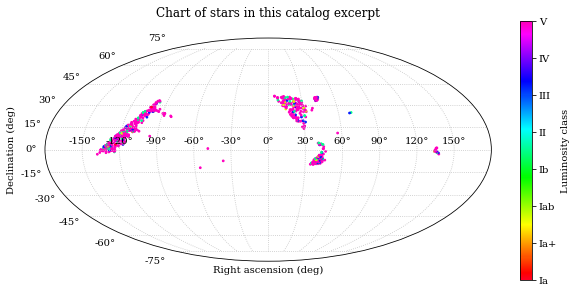

In [55]:
ra = coord.Angle(objList.loc[all_good,'RA'],unit=u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(objList.loc[all_good,'DE'],unit=u.degree)
fig, ax = plt.subplots(figsize=(8,6),subplot_kw={'projection': "mollweide"})
ax.grid(color='silver', linestyle=':')
ax.scatter(ra.radian, dec.radian,c=[lumClasses.index(lumCl) for lumCl in [objList.loc[i,'subCl'][2:].strip() for i in distances.index]],cmap='gist_rainbow',s=3)

plt.title("Chart of stars in this catalog excerpt\n")
plt.xlabel("Right ascension (deg)")
plt.ylabel("Declination (deg)")

cmap = plt.cm.gist_rainbow
norm = mpl.colors.Normalize(vmin=1, vmax=len(lumClasses))
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
cb.ax.set_yticklabels(lumClasses)
cb.set_label('Luminosity class')

plt.savefig('class_skymap.png',bbox_inches='tight')
plt.show()

### Visualize the discrepancies between the two temperature calculations

One is calculated using the converted spectrum and Wien's law. The other is from the stars spectral class. All differences over 1000K have been discarded.

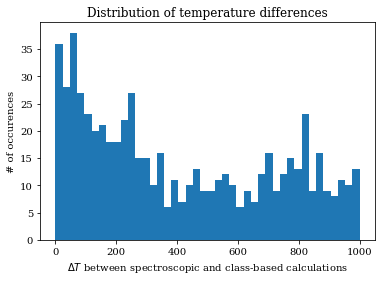

In [62]:
plt.hist(tempdiffs,bins=42)
plt.xlabel("$\Delta T$ between spectroscopic and class-based calculations")
plt.ylabel("# of occurences")
plt.title("Distribution of temperature differences")
plt.show()